In [1]:
import pandas as pd
import numpy as np
import latex
# import seaborn as sns

In [2]:
# making plots look good
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['text.usetex'] = False
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 14, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':4, 'lines.linewidth':1.5,'xtick.labelsize':14})

cm = 1/2.54
H = 14.56
W = 9

# Lexical: phones + phones with space
# fig, ax = plt.subplots(1,1, figsize=(H*cm,W*cm), constrained_layout=True)

In [3]:
METRIC_NAMES = {
    "ValidationMetric": "(mae(snr)+mae(c50)+(1-fscore(vad))/3",
    # "ValidationMetric": r'\frac{(1-F-score(VAD))+NMAE(SNR)+NMAE(C50)}{3}',
    "c50ValMetric": "C50 MAE",
    "snrValMetric": "SNR MAE",
    "vadValMetric": "VAD F-score"
}
METRICS = [
    "ValidationMetric",
    "c50ValMetric",
    "snrValMetric",
    "vadValMetric"
]
PARAMS = [
    "dropout",
    "duration",
    "batch_size",
    "hidden_size",
    "num_layers"
]
PARAMS_NAMES = {
    "dropout": "Dropout",
    "duration": "Duration (s)",
    "batch_size": "Batch size",
    "hidden_size": "LSTM Hidden size",
    "num_layers": "Number of LSTM layers"
}
PARAMS_PLOT = {
    "vadValMetric": {
        "ratio": 1.7,
        "scattering": 0.122,
        "widths": 0.6
    },
    "ValidationMetric": {
        "ratio": 120,
        "scattering": 0.095,
        "widths": 0.4
    },
    "c50ValMetric": {
        "ratio": 1,
        "scattering": 0.122,
        "widths": 0.6
    },
    "snrValMetric": {
        "ratio": 4,
        "scattering": 0.095,
        "widths": 0.5
    }
}

In [4]:
# load csv with all the data
data = pd.read_csv("gridsearch_models_data.csv", index_col=0)
data.head()

,duration,batch_size,hidden_size,num_layers,dropout,stride,c50ValMetric,snrValMetric,vadOptiTh,vadValMetric,ValidationMetric,TrainLoss,vadLoss,snrLoss,c50Loss,best_epoch,name
0,6,128,256,2,0.5,10,4.115280,4.425280,0.500000,0.980394,0.062776,0.375091,0.087604,0.221811,0.065675,16.0,dur_6_bs_128_lstm_hs_256_lstm_nl_2_dropout_0.5
1,2,32,128,2,0.5,10,6.478751,4.785206,0.320003,0.968302,0.079427,0.520075,0.177578,0.165495,0.177000,3.0,dur_2_bs_32_lstm_hs_128_lstm_nl_2_dropout_0.5
2,6,64,128,2,0.5,10,4.462360,4.466281,0.420000,0.980367,0.064653,0.425255,0.090437,0.263309,0.071509,11.0,dur_6_bs_64_lstm_hs_128_lstm_nl_2_dropout_0.5
3,2,128,256,2,0.5,10,6.568472,4.694459,0.360000,0.969030,0.079985,0.633430,0.179202,0.240350,0.213878,2.0,dur_2_bs_128_lstm_hs_256_lstm_nl_2_dropout_0.5
4,6,64,128,2,0.0,10,4.282768,4.439222,0.380000,0.980692,0.063453,0.392062,0.087199,0.241391,0.063472,14.0,dur_6_bs_64_lstm_hs_128_lstm_nl_2_dropout_0


In [5]:
def scattered_boxplot(
    data: pd.DataFrame,
    param_to_monitor: str = "dropout",
    metric: str = 'ValidationMetric',
    figure_path: str = None
) -> None:
    
    ratio = PARAMS_PLOT[metric]["ratio"]
    scattering = PARAMS_PLOT[metric]["scattering"]
    widths = PARAMS_PLOT[metric]["widths"]

    possible_values = np.sort(data[param_to_monitor].unique())
    if metric == "vadValMetric":
        coef = 100
    else:
        coef = 1

    values = dict()
    for value in possible_values:
        values[value] = data[data[param_to_monitor] == value][metric].reset_index(drop=True) * coef
    # Rearrange the data for plotting
    df = pd.DataFrame(values)

    default_arch = data[data["name"] == 'dur_2_bs_32_lstm_hs_128_lstm_nl_2_dropout_0']
    val_default_arch = default_arch[metric] * coef

    vals, names, xs = [],[],[]
    for i, col in enumerate(df.columns):
        vals.append(df[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, scattering, df[col].values.shape[0]))
        # adds jitter to the data points - can be adjusted
    
    fig, ax = plt.subplots(1,1, figsize=(H*cm,W*cm), constrained_layout=True)
    ax.set_aspect(ratio)
    ax.boxplot(vals, labels=names, widths=widths)
    palette = ['r', 'g', 'b', 'y']
    markers = ['.', '^', 'x', '*']
    for x, val, c, m in zip(xs, vals, palette, markers):
        ax.scatter(x, val, alpha=0.5, color=c, marker=m, s=60)

    # y axis
    plt.xlabel(param_to_monitor.replace('_', ' ').capitalize(), fontweight='normal', fontsize=14)
    plt.ylabel(METRIC_NAMES[metric], fontweight='normal', fontsize=14)

    # default architecture
    ax.axhline(y=float(val_default_arch), color='k', linestyle='--', alpha=0.7, linewidth=3, label='Default arch.')
    ax.legend(bbox_to_anchor=(0.31, 1.15), loc=2, borderaxespad=0., framealpha=1, facecolor ='white', frameon=True)

    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    if not figure_path:
        figure_path = f"figures/{param_to_monitor}_{metric}.png"
    plt.savefig(figure_path, bbox_inches="tight")#, dpi=300)


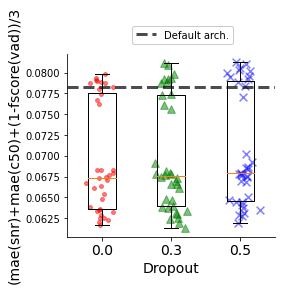

In [90]:
scattered_boxplot(data, metric="ValidationMetric", figure_path="dropout_vad")

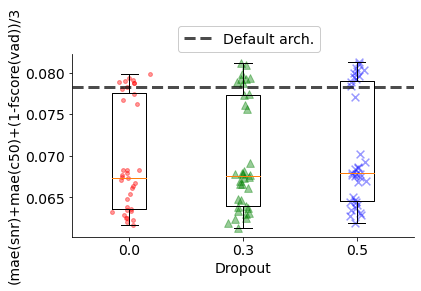

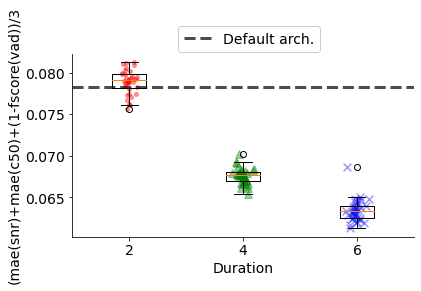

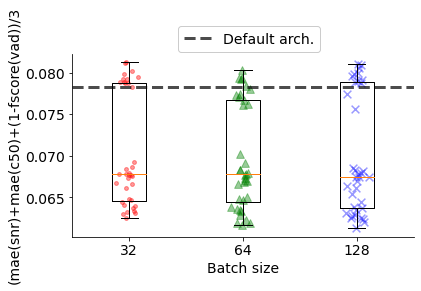

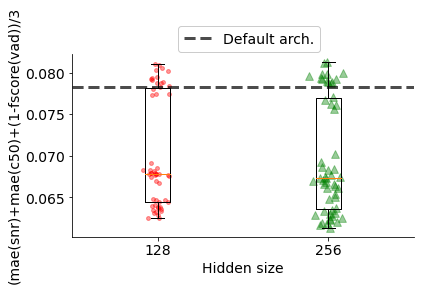

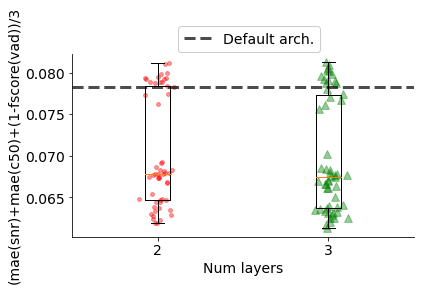

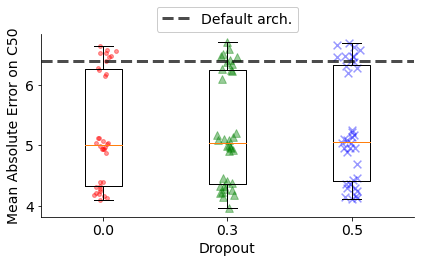

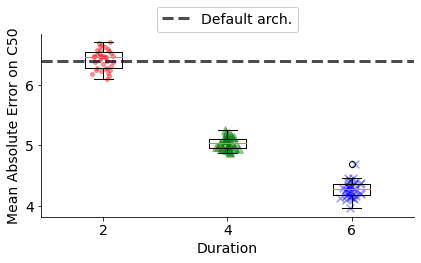

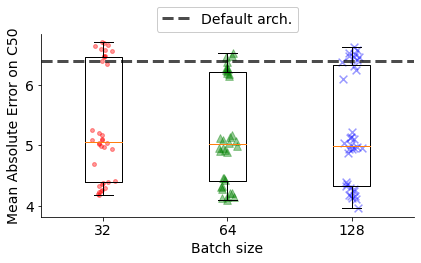

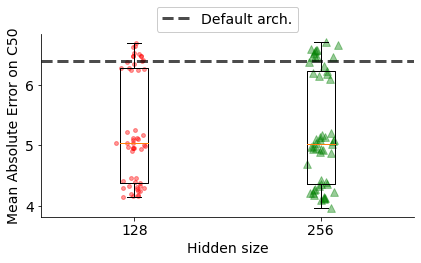

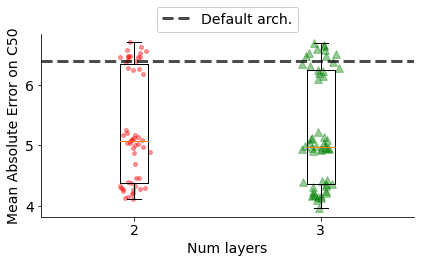

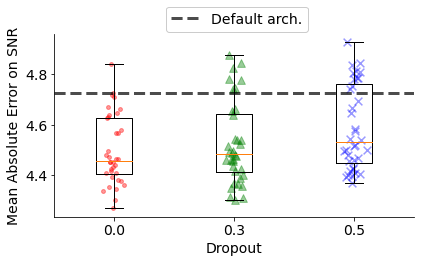

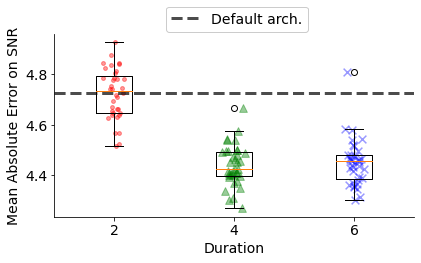

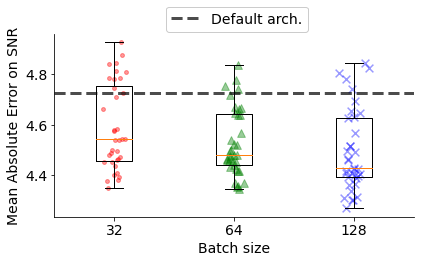

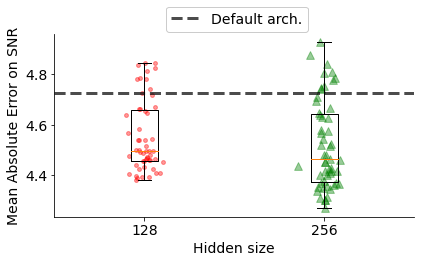

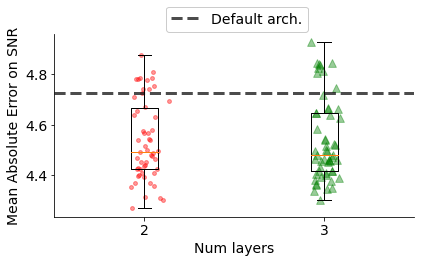

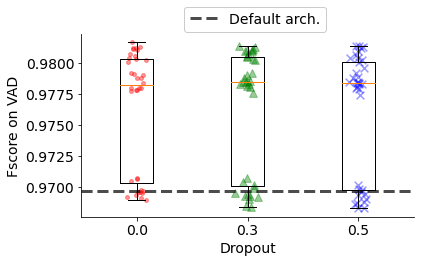

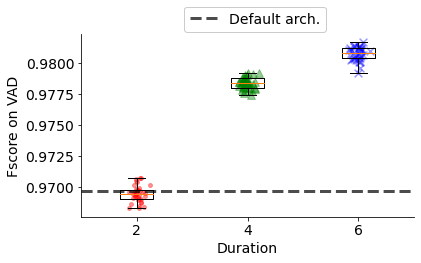

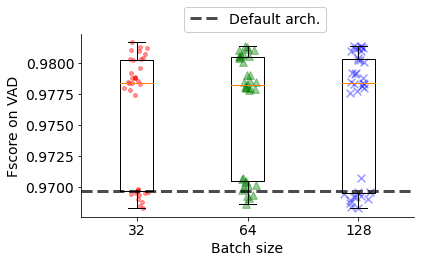

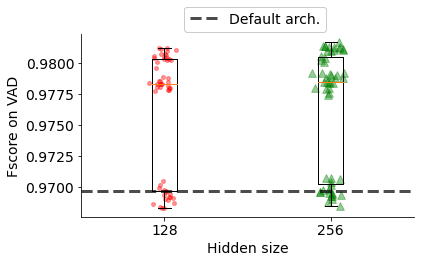

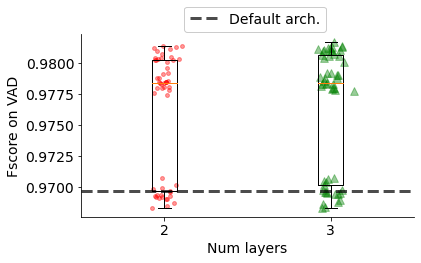

In [200]:
# generate all plots
for metric in METRICS:
    for param in PARAMS:
        scattered_boxplot(data, param, metric)

In [103]:
def best_models(data):
    metrics_min = ["ValidationMetric", "snrValMetric", "c50ValMetric"]
    metrics_max = ["vadValMetric"]
    best = dict()
    for metric in metrics_min:
        index = data[metric].idxmin()
        values = {
            "model": data.iloc[index]['name'],
            "value": data.iloc[index][metric]
        }
        best[metric] = values

    for metric in metrics_max:
        index = data[metric].idxmax()
        values = {
            "model": data.iloc[index]['name'],
            "value": data.iloc[index][metric]
        }
        best[metric] = values

    return best

In [105]:
best_models(data)

{'ValidationMetric': {'model': 'dur_6_bs_128_lstm_hs_256_lstm_nl_3_dropout_0.3',
  'value': 0.0612963065505027},
 'snrValMetric': {'model': 'dur_4_bs_128_lstm_hs_256_lstm_nl_2_dropout_0',
  'value': 4.264803886413574},
 'c50ValMetric': {'model': 'dur_6_bs_128_lstm_hs_256_lstm_nl_3_dropout_0.3',
  'value': 3.9617185592651367},
 'vadValMetric': {'model': 'dur_6_bs_32_lstm_hs_256_lstm_nl_3_dropout_0',
  'value': 0.9816452860832214}}

In [13]:
best = data[data["name"] == 'dur_6_bs_128_lstm_hs_256_lstm_nl_3_dropout_0.3']
print(f"best epoch : {best['best_epoch']}")
print(f"opt thresh : {best['vadOptiTh']}")


best epoch : 51    15.0
Name: best_epoch, dtype: float64
opt thresh : 51    0.42
Name: vadOptiTh, dtype: float64
